In [2]:
from bee_track.tracking import TagAnalysisFromImage
from glob import glob 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json

from scipy.optimize import minimize

In [3]:
beetrackfn = '/home/mike/Documents/Research/bee/photos2022/020622/bee_track.json'
labeldata = json.load(open(beetrackfn,'r'))

In [510]:
def intgaussian(centre,width,height,tile,steps = 10):
    """
    For a Gaussian centred at 'centre', with 'width' and 'height'
    what is the integral over the rectangle in tile [x1,y1,x2,y2]
    """
    xstep = np.linspace(tile[0],tile[2],steps)
    ystep = np.linspace(tile[1],tile[3],steps)
    p = np.array(np.meshgrid(xstep,ystep)).reshape(2,steps*steps).T
    #return np.sum(height * np.exp(-np.sum((p - centre)**2/(2*width**2),1)))*((xstep[1]-xstep[0])*(ystep[1]-ystep[0]))
    return np.mean(height * np.exp(-np.sum((p - centre)**2/(2*width**2),1)))


class TagAnalysis():
    
    def f(self,x):
        centre = x[:2] #0,1
        width = x[2]   #2
        height = x[3:6] #3,4,5
        bg = x[6] #6
        error = 0
        for cx in range(self.tagimg.shape[0]):
            for cy in range(self.tagimg.shape[1]):
                h = height[self.colmap[cx,cy]]
                tile = [cx,cy,cx+1,cy+1]
                pred = intgaussian(centre,width,h,tile)+bg
                if pred>255: pred = 255
                act = self.tagimg[cx,cy]
                error += (pred-act)**2
                #plt.scatter(pred,act,c=['r','g','b'][colmap[cx,cy]])
                self.error_record.append(error)
        return error        
    
    def compute(self,tol=0.0001):
        self.error_record = []
        self.colmap = np.full_like(self.tagimg,-1).astype(int)
        self.colmap[::2,::2] = 0 #red
        self.colmap[1::2,::2] = 1 #green
        self.colmap[::2,1::2] = 1 #green
        self.colmap[1::2,1::2] = 2 #blue            
        res = minimize(self.f,x0=[4,4,0.5,20,20,20,1],bounds=[(2,6),(2,6),(0.3,2.0),(0,1000),(0,1000),(0,1000),(0,10)],tol=tol)
        self.res = res
        h = res['hess_inv'].todense()
        self.rgberr = res['x'][3:6],np.sqrt(np.diag(h))[3:6]
        return self.rgberr
    
    def __init__(self, track):
        """
        Pass the photo and the 'track' dictonary (containing an 'x' and 'y' element in the dictionary).
        
        TODO: Assume patch is 40x40
        """
        x = track['x']
        y = track['y']

        #round to even pixels to ensure Bayer structure remains intact
        #self.x = (x//2)*2
        #self.y = (y//2)*2
        #self.img = img
        
        #TODO Assert the x and y are all in the img
        #self.tagimg = img[y-self.tagbox:y+self.tagbox,x-self.tagbox:x+self.tagbox]
        self.tagimg = track['patch']#'img[y-self.tagbox:y+self.tagbox,x-self.tagbox:x+self.tagbox]
        self.tagimg = self.tagimg[14:-14,14:-14] #bit smaller.
        if y%2==1:
            self.tagimg = self.tagimg[1:,:]
        if x%2==1:
            self.tagimg = self.tagimg[:,1:]


    def computefast(self,skipsaturated=False):
        rgb = []
        tagimg = self.tagimg
        if skipsaturated:
            tagimg = self.tagimg.copy().astype(float)
            tagimg[tagimg==255] = np.NaN
        rgb.append(np.nanmean(tagimg[::2,::2]))
        rgb.append(np.nanmean(tagimg[1::2,::2])/2+np.nanmean(tagimg[::2,1::2])/2)
        rgb.append(np.nanmean(tagimg[1::2,1::2]))       
        return np.array(rgb),np.zeros(3)
    

class WholeImageAnalysis():
    def __init__(self,img):
        self.img = img
        
    def conv2d(self,a, f):
        s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
        strd = np.lib.stride_tricks.as_strided
        subM = strd(a, shape = s, strides = a.strides * 2)
        return np.einsum('ij,ijkl->kl', f, subM)

    def get_focus(self,source='centre'):
        #self.kern = np.array([[1,1,1],[1,-8,1],[1,1,1]])
        self.kern = np.array([[1,0,1,0,1],[0,0,0,0,0],[1,0,-8,0,1],[0,0,0,0,0],[1,0,1,0,1]])
        #self.kern = np.array([[   0,   0,   0,   0,   1,   0,   0,   0,   0],
        #[   0,   0,   1,   2,   3,   2,   1,   0,   0],
        #[   0,   1,   3,   5,   5,   5,   3,   1,   0],
        #[   0,   2,   5,  -1, -15,  -1,   5,   2,   0],
        #[   1,   3,   5, -15, -47, -15,   5,   3,   1],
        #[   0,   2,   5,  -1, -15,  -1,   5,   2,   0],
        #[   0,   1,   3,   5,   5,   5,   3,   1,   0],
        #[   0,   0,   1,   2,   3,   2,   1,   0,   0],
        #[   0,   0,   0,   0,   1,   0,   0,   0,   0]])

        img = self.img.astype(float)
        img -= np.mean(img)
        img /= np.sort(np.abs(img.flatten()))[-100] #np.std(img)
        
        if source=='centre':
            coordtograb = np.array(img.shape)//2
        if source=='topofterrain':
            coordtograb = [0,0]
            level = np.mean(img,1)
            coordtograb[0] = np.argmax(level[:-50]-level[50:])+300
            coordtograb[1] = img.shape[1]//2
        if source=='whole':    
            convedimg = self.conv2d(img,kern)
        else:
            #img = img[coordtograb[0]-300:coordtograb[0]+300,coordtograb[1]-300:coordtograb[1]+300]
            convedimg = self.conv2d(img[coordtograb[0]-300:coordtograb[0]+300,coordtograb[1]-300:coordtograb[1]+300],kern)
        
        #img -= np.median(img)
        #print(np.mean(np.abs(img)))
        #img /= np.mean(np.abs(img)) #np.max(np.abs(img))#np.std(img)
        
        
        #s1 = np.median(np.max(np.abs(np.diff(img[::2,::2])),1))
        #s2 = np.median(np.max(np.abs(np.diff(img[::6,::6])),1))
        #s1 = np.mean(np.abs(np.diff(img[::2,::2])))
        #s2 = np.mean(np.abs(np.diff(img[::2,::4])))
        #print(s1,s2)
        #return s1/s2
        #blurs = np.sort(convedimg.flatten())
        ##return np.std(blurs[100:-100])
        #self.convedimg = convedimg        
        #return np.median(blurs[-1000:])
        return np.std(convedimg)

class TagAnalysisFromImage(TagAnalysis):
    def __init__(self, img, tagloc):
        
        track = {}
        track['x'] = tagloc[0]
        track['y'] = tagloc[1]
        track['patch'] = img[tagloc[1]-20:tagloc[1]+20,tagloc[0]-20:tagloc[0]+20]
        super().__init__(track)

1 1.92
1 2.15
1 2.11
1 2.06
1 1.56
1 0.70
1 2.36
1 2.20
1 2.42
1 2.48
1 2.31
1 2.40
1 2.32
1 2.54
1 2.58
1 1.06
1 0.52
1 2.57
1 2.55
1 2.66
1 2.55
1 4.66
1 2.70
1 2.71
1 0.96
1 2.39
1 2.81
1 3.04
1 4.29
1 1.96
1 3.54
1 4.35
1 2.50
2 2.82
2 2.80
2 2.89
2 2.62
2 2.78
2 2.76
2 2.83
2 2.64
2 7.05
2 2.61
2 1.17
2 2.89
2 2.86
2 2.85
2 2.87
2 2.88
2 7.66
2 3.33
2 2.81
2 2.83
2 2.86
2 2.82
2 4.97
2 6.17
2 1.24
2 2.98
2 3.76
2 6.27
2 2.96
2 0.64
2 2.65
2 2.68
2 2.81
2 2.86
2 5.59
2 2.66
3 1.68
3 1.79
3 1.47
3 1.76
3 1.50
3 5.40
3 1.68
3 1.50
3 0.17
3 1.25
3 0.51
3 1.58
3 1.93
3 1.84
3 1.88
3 5.09
3 1.82
3 1.06
3 1.84
3 1.90
3 2.04
3 1.87
3 1.88
3 1.86
3 0.88
3 2.00
3 2.73
3 1.80
3 1.93
3 2.10
3 2.08
3 2.00
3 4.18
3 0.27
3 2.11
4 0.16
4 0.21
4 0.67
4 1.84
4 2.07
4 0.39
4 0.78
4 0.65
4 0.70
4 0.96
4 0.69
4 0.63
4 0.68
4 1.02
4 0.94
4 1.13
4 1.10
4 2.05
4 2.53
4 1.11
4 1.09
4 1.07
4 1.08
4 2.00
4 1.08
4 1.02
4 1.06
4 0.99
4 0.94
4 1.06
4 1.12
4 2.09
4 1.27
4 0.11
4 1.24
4 1.19
4 1.22
4 1.19
4 1.21

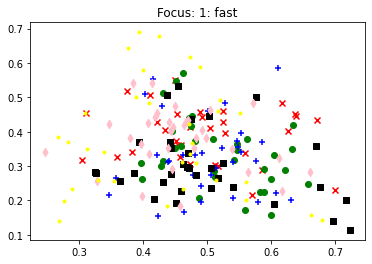

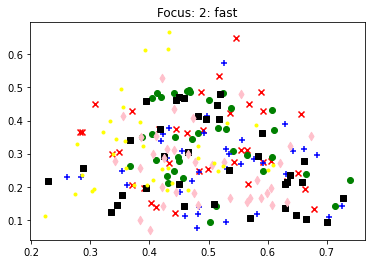

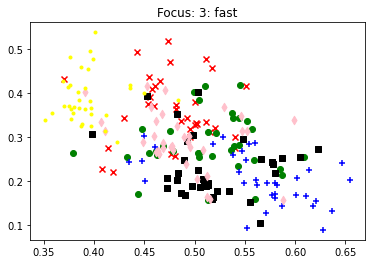

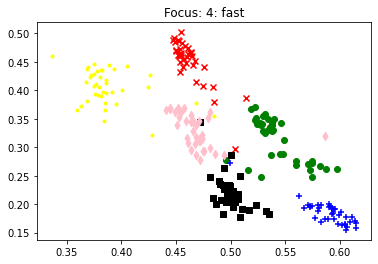

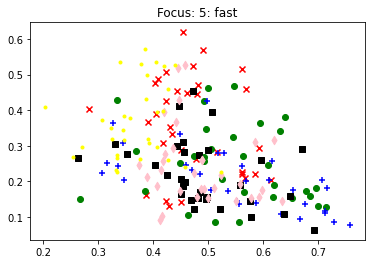

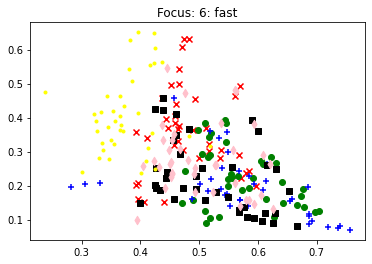

In [511]:
for focus in range(1,7):
    
    fastcolourdata = [[],[],[],[],[],[]]
    goodcolourdata = [[],[],[],[],[],[]]
    for imnum,labelimdata in labeldata['0'].items():
        if len(labelimdata)==0: continue
        fn = labelimdata[0]['fn']
        if "mf%d" % focus not in fn: continue
        photo_obj = np.load(fn,allow_pickle=True)
        img = photo_obj['img']
        wia = WholeImageAnalysis(img)
        wia.get_focus(source='centre')
        print("%d %0.2f" % (focus,wia.get_focus(source='topofterrain'))) #'topofterrain')))#'whole')))#'topofterrain')))
        #print("%d %0.2f" % (focus,np.median(np.abs(wia.convedimg.flatten()))))
        for label in labelimdata:
            #print("%5d %5d (%s)"%(label['x'],label['y'],label['label']),end=" --")

            #img[::2,::2] = 255
            tafi = TagAnalysisFromImage(img,np.array([int(label['x']),int(label['y'])]))
            fastcols,_ = tafi.computefast(skipsaturated=True)
            #print("%5d %5d %5d" % tuple(cols))
            fastcolourdata[int(label['label'][8])].append(fastcols)
            #goodcols,_ = tafi.compute()
            #print("%d %d %d | %d %d %d" % (tuple(fastcols)+tuple(goodcols)))
            #goodcolourdata[int(label['label'][8])].append(goodcols)
        #plt.figure()
        #plt.hist(wia.convedimg.flatten(),np.arange(-1000,1000,50),log=True);
        
        
    
    if len(fastcolourdata[0])==0: continue
    #for title, colourdata in zip(['fast','good'],[fastcolourdata,goodcolourdata]):
    for title, colourdata in zip(['fast'],[fastcolourdata]):
        plt.figure()
        plt.title("Focus: %d: %s" % (focus,title))
        markers = ['x','o','+','s','d','.']
        colours = ['r','g','b','k','pink','yellow']
        for i,cd in enumerate(colourdata):
            cd = np.array(cd)
            normcd = cd / np.sum(cd,1)[:,None]
            colourx = normcd[:,2] + normcd[:,0]/2
            coloury = normcd[:,0]
            plt.scatter(colourx,coloury,marker=markers[i],c=colours[i])

0.7849837457539289

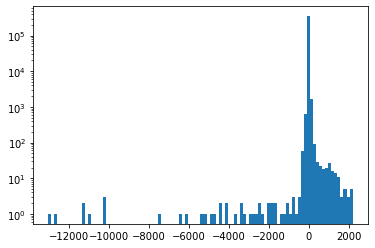

12.748346638217367


In [310]:
#plt.plot(np.fft.fft(img[400,400:600])[:10])
#plt.plot(np.fft.fft(test[400,400:600])[:10])

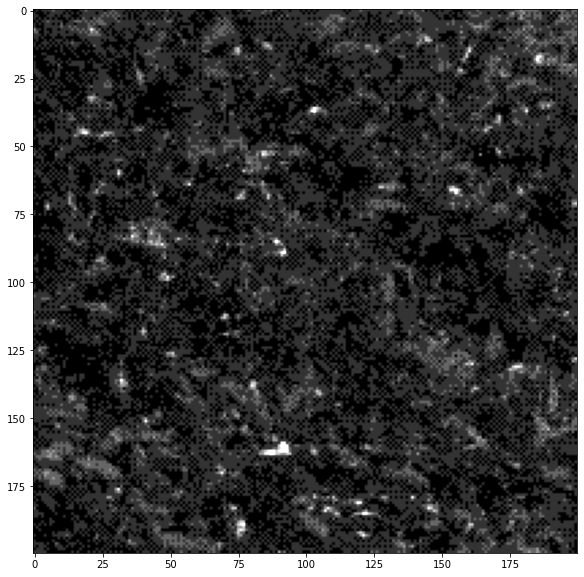

In [311]:
plt.figure(figsize=[20,10])
plt.imshow(img[400:600,400:600],clim=[0,5],cmap='gray')

37.95157275050923

In [329]:
blurs = np.sort(test.flatten())
np.std(blurs[100:-100])

26.793034495351534

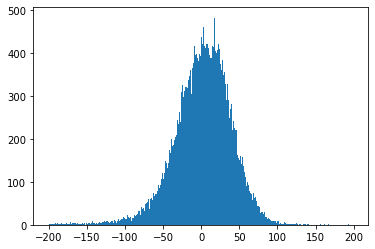

In [322]:
plt.hist(test2.flatten(),np.arange(-200,200));

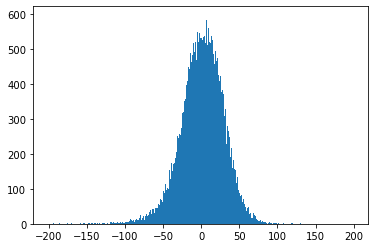

In [323]:
plt.hist(test.flatten(),np.arange(-200,200));

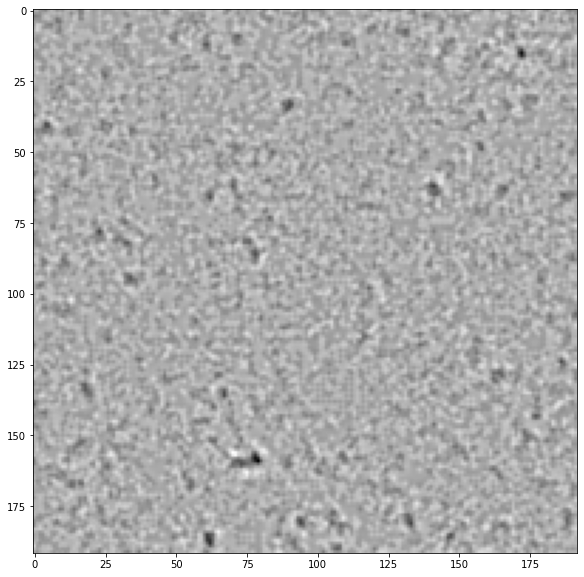

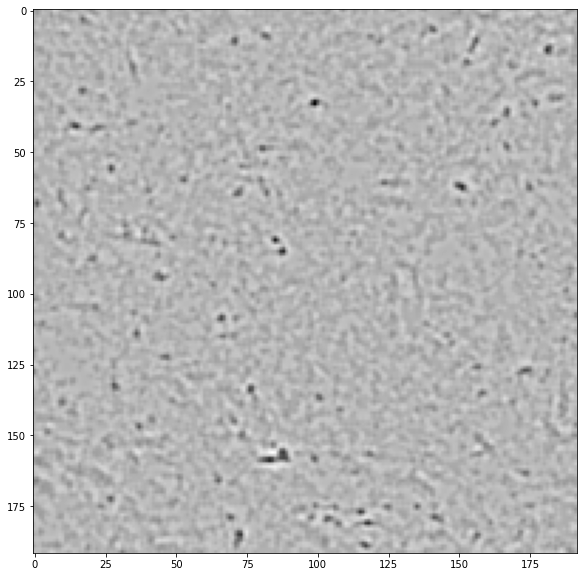

In [321]:
plt.figure(figsize=[20,10])
plt.imshow(test,cmap='gray')
plt.figure(figsize=[20,10])
plt.imshow(test2,cmap='gray')

In [ ]:
s = 0
for x in range(-4,5):
    vs = []
    for y in range(-4,5):
        a = (1/1)*np.exp(-0.5*(x**2+y**2)/(1.7**2))-1.985*(1/0.5)*np.exp(-0.5*(x**2+y**2)/(0.8**2))
        s+=int(a*16)
        vs.append("%4.0f" % int(16*a))
    print(",".join(vs),end="")
    print("]\n[",end="")
print(s)